In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, pearsonr


In [35]:
# CSV DE PRUEBA PARA TESTEAR LA FUNCIÓN
df = pd.read_csv("./data/titanic.csv")

# Se eliminan las columnas duplicadas, la columna 'deck' por falta de datos y las líneas con nulo en 'embark_town'
df.drop(columns = ["sex","sibsp","parch","embarked","adult_male","deck"], inplace = True)
df.dropna(subset = ["embark_town"], inplace = True)

# Se imputan los nulos de 'age' con la media correspondiente a su 'who'
media_age_man = df.loc[(df.who == "man")&(df.age.notnull()), "age"].mean()
media_age_woman = df.loc[(df.who == "woman")&(df.age.notnull()), "age"].mean()
media_age_child = df.loc[(df.who == "child")&(df.age.notnull()), "age"].mean()
df.loc[(df.who == "man")&(df.age.isna()), "age"] = media_age_man
df.loc[(df.who == "woman")&(df.age.isna()), "age"] = media_age_woman
df.loc[(df.who == "child")&(df.age.isna()), "age"] = media_age_child

# Se crea una variable nueva relacionada con 'age'
df["newcol"] = (np.log10(df["age"]))

In [12]:
# CSV sin tratar variables para testear errores
df_err = pd.read_csv("./data/titanic.csv")

In [57]:
# ---------------------------------
# 1.- describe_df
#----------------------------------
def describe_df(df: pd.DataFrame):
    """
    Esta función recibe un dataframe, coge sus columnas y sustituye las filas por información relativa al dataframe de entrada.

    Argumentos:
    df: cualquier dataframe.

    Retorna:
    DataFrame: retorna un nuevo Dataframe que refleja el DataType, Missings (%), unique_values y cardinalidad (%) por columna del DataFrame de entrada.
    """
    
    data_tipo = df.dtypes.astype(str)
    nulos = df.isnull().mean() * 100
    unicos = df.nunique()
    cardinalidad = (unicos/len(df)) * 100

    rows = {'DATA_TYPE': data_tipo,'MISSINGS (%)':nulos, 'UNIQUE_VALUES': unicos, 'CARDIN (%)': cardinalidad}

    return_df = pd.DataFrame(rows)
    return_df = return_df.T

    return return_df


# ---------------------------------
# 2.- tipifica_variables
#----------------------------------
def tipifica_variables(df: pd.DataFrame, umbral_categoria: int, umbral_continua: float):
    """
    Recibe un DataFrame y parámetros para tipificar las columnas

    Argumentos:
    df: cualquier dataframe.
    umbral_categoria: marca el límite a partir el cual se va a considerar una variable categorica.
    umbral_continua: marca el límite a partir el cual se va a diferenciar entre numérica continua o discreta,

    Retorna:
    DataFrame: un dataframe nuevo, donde las columnas del de entrada se convierten en filas y cada columna refleja el tipo de la variable.
    """
    
    filas = []
    tipos = []

    for col in df:
        n_unique = df[col].nunique()
        cardinalidad_porcentaje = (n_unique / len(df)) * 100

        if n_unique == 2:
            tipo = 'Binaria'

        elif n_unique < umbral_categoria:
            tipo = 'Categorica'

        else:

            if cardinalidad_porcentaje >= umbral_continua:
                tipo = 'Numérica Continua'
            else:
                tipo = 'Numérica Discreta'

        filas.append(col)
        tipos.append(tipo)

    return_df = pd.DataFrame({
        'nombre_variable': filas,
        'tipo_sugerido': tipos
    })

    return return_df


# ---------------------------------
# 3.- get_features_num_regression
#----------------------------------
def get_features_num_regression(df, target_col, umbral_corr, pvalue=None):
    """
    Devuelve una lista de columnas numéricas cuya correlación con la variable target es
    mayor (en valor absoluto) que el umbral indicado. Opcionalmente, también filtra por
    significación estadística mediante p-value.

    Argumentos:
    - df (pd.DataFrame): DataFrame de entrada.
    - target_col (str): Nombre de la variable target (debe ser numérica).
    - umbral_corr (float): Umbral mínimo de correlación (entre 0 y 1).
    - pvalue (float, opcional): Nivel de significación deseado (valor entre 0 y 1). 
                               Si es None, no se aplica test de hipótesis.

    Retorna:
    list or None: Lista de columnas que cumplen los criterios, o None si hay error en los parámetros.
    """

    # Validaciones básicas
    if not isinstance(df, pd.DataFrame):  # que df sea un DataFrame
        print("Error: El argumento 'df' debe ser un DataFrame.")
        return None
    if target_col not in df.columns:  # que la columna objetivo exista
        print(f"Error: La columna '{target_col}' no se encuentra en el DataFrame.")
        return None
    if not np.issubdtype(df[target_col].dtype, np.number):  # que la columna objetivo sea numérica
        print("Error: La variable 'target_col' debe ser numérica.")
        return None
    if not (0 <= umbral_corr <= 1):   # validación el umbral de correlación
        print("Error: 'umbral_corr' debe estar entre 0 y 1.")
        return None
    if pvalue is not None:
        if not (0 < pvalue < 1):  # validación del p-value si se proporciona
            print("Error: Si se indica, 'pvalue' debe estar entre 0 y 1.")
            return None

    # Seleccionar variables numéricas (excluyendo la target)
    num_cols = df.select_dtypes(include=[np.number]).columns.drop(target_col)

    selected_features = []

    for col in num_cols:
        # Eliminar filas con NaN en las columnas involucradas
        valid_data = df[[col, target_col]].dropna()
        
        if valid_data.shape[0] < 2:
            continue  # No se puede calcular correlación con menos de 2 datos
        
        corr, p = pearsonr(valid_data[col], valid_data[target_col])
        
        if abs(corr) >= umbral_corr:
            if pvalue is None or p < (1 - pvalue):
                selected_features.append(col)

    return selected_features


# ---------------------------------
# 4.- plot_features_num_regression
#----------------------------------
def plot_features_num_regression(df, target_col="", columns=[], umbral_corr=0, pvalue=None):
    """
    Genera pairplots entre la variable objetivo y las variables numéricas que superen un umbral
    de correlación (y opcionalmente un test de significación estadística). Los gráficos se generan 
    en bloques de hasta 5 variables (incluyendo el target). Devuelve las variables que cumplen 
    los criterios.

    Argumentos:
    - df (pd.DataFrame): DataFrame de entrada.
    - target_col (str): Nombre de la variable objetivo. Obligatorio.
    - columns (list of str): Lista de variables numéricas candidatas. Si se deja vacío, se usan todas.
    - umbral_corr (float): Valor mínimo absoluto de correlación. Por defecto 0.
    - pvalue (float or None): Nivel de significación (0 < p < 1). Si es None, no se aplica test.

    Retorna:
    list or None: Lista de variables que cumplen los criterios, o None si hay error en los parámetros.
    """

    # Validaciones básicas
    if not isinstance(df, pd.DataFrame):  # que df sea un DataFrame
        print("Error: El argumento 'df' debe ser un DataFrame.") 
        return None
    if target_col not in df.columns: # que la columna objetivo exista
        print(f"Error: La columna '{target_col}' no está en el DataFrame.")
        return None
    if not np.issubdtype(df[target_col].dtype, np.number):  # que la columna objetivo sea numérica
        print("Error: La variable 'target_col' debe ser numérica.")
        return None
    if not (0 <= umbral_corr <= 1):   # validación el umbral de correlación
        print("Error: 'umbral_corr' debe estar entre 0 y 1.")
        return None
    if pvalue is not None and not (0 < pvalue < 1):  # validación del p-value si se proporciona
        print("Error: 'pvalue' debe estar entre 0 y 1 si se indica.")
        return None

    # Si columns está vacío, se usan todas las variables numéricas excepto la target
    if not columns:
        columns = df.select_dtypes(include=np.number).columns.drop(target_col).tolist()
    else:
        # Validación de que las columnas existan y sean numéricas
        valid_cols = []
        for col in columns:
            if col in df.columns and np.issubdtype(df[col].dtype, np.number):
                valid_cols.append(col)
            else:
                print(f"Advertencia: Se ignora la columna '{col}' (no existe o no es numérica).")
        columns = valid_cols

    # Lista final de columnas que cumplen los criterios
    selected_columns = []

    for col in columns:
        valid_data = df[[col, target_col]].dropna()
        if valid_data.shape[0] < 2:   # si quedan menos de 2 datos, no tiene sentido calcular correlación -> se omite
            continue

        corr, p = pearsonr(valid_data[col], valid_data[target_col])

        if abs(corr) >= umbral_corr:
            if pvalue is None or p < (1 - pvalue):
                selected_columns.append(col)

    if not selected_columns:
        print("No se encontraron variables que cumplan los criterios.")
        return []

    # Agrupación en bloques de hasta 4 columnas + target
    max_cols = 4
    for i in range(0, len(selected_columns), max_cols):
        subset = selected_columns[i:i + max_cols]
        pairplot_cols = [target_col] + subset
        sns.pairplot(df[pairplot_cols].dropna())
        plt.suptitle(f"Pairplot: {', '.join(pairplot_cols)}", y=1.02)
        plt.show()

    return selected_columns


# ---------------------------------
# 5.- get_features_cat_regresion
#----------------------------------
def get_features_cat_regresion(df, target_col, pvalue = 0.05):
    """
    Función de selección de variables categóricas con relación estadística frente a una variable numérica de alta cardinalidad.

    Argumentos:
    -----------
    df : DataFrame, parámetro obligatorio sin valor por defecto.
    \tSin valores NaN en las variables que se vayan a comparar estadísticamente.
    target_col : str, parámetro obligatorio sin valor por defecto.
    \tSeñala una variable numérica de alta cardinalidad contenida en el DataFrame (df), 
    \tcontra la que se efectuarán las comparaciones estadísticas.        
    pvalue : str, opcional. Valor por defecto = 0.05
    \tProbabilidad de que un valor estadístico calculado sea posible dada una hipótesis nula cierta. 
    \tEn caso de que el valor calculado sea superior se considerarán las variables como no relacionadas.
    \tSi el valor calculado es igual o inferior a la probabilidad ('pvalue'), 
    \tlas variables se consideran como relacionadas estadísticamente.

    Retorna:
    --------
    Devuelve una lista con las columnas categóricas del dataframe cuyo test de relación con la columna designada por 'target_col' 
    supere en confianza estadística ('p_valor') el test de relación correspondiente ('U de Mann_Whitney' o 'Anova'). 
    \n        
    """
    
    try:        
        features = df.columns.tolist()
        features.remove(target_col)
        
        # Se comprueba que la variable target sea una variable numérica de alta cardinalidad.
        card_target = (len(df[target_col].unique())/len(df))*100
        if card_target < 1:
            msg = f"La variable 'target' debe ser una variable numérica de alta cardinalidad."
            print(msg)
            return None

        # Separa las variables entre categóricas y numéricas.
        lista_categoricas_relacionadas = []
        feat_cat = []
        feat_num = []
        for col in features:
            cardinalidad = (len(df[col].unique())/len(df))*100
            if cardinalidad < 1:
                feat_cat.append(col)
            else:
                feat_num.append(col)
        
        # Determina qué prueba se hará en función de cuántos valores únicos tiene la variable categórica.
        for var in feat_cat:
            num_uniq = len(df[var].unique())
            list_uniq = df[var].unique()
            if num_uniq == 2:            
                #Se aplica Mann-Whitney.   
                    #1 Separar los datos en dos grupos según la variable categórica.
                grupo_a = df.loc[df[var] == list_uniq[0]][target_col]
                grupo_b = df.loc[df[var] == list_uniq[1]][target_col]
                    #2 Aplicar la prueba y mostrar los resultados.
                u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)
                    #3 Interpretación del valor p (p-value).
                if p_valor <= pvalue:
                    lista_categoricas_relacionadas.append(var) 
                elif np.isnan(p_valor):
                    msg = f"Las variables contienen valores nulos que impiden efectuar comparaciones estadísticas."
                    print(msg)
                    return None
            else:
                #Se aplica Anova.
                    #1 Separar en grupos según los valores de las categorías.
                sep = [df[df[var] == elem][target_col] for elem in list_uniq]
                    #2 Aplicamos el ANOVA.
                f_valor, p_valor = stats.f_oneway(*sep)         
                    #3 Interpretación del ANOVA.
                if p_valor <= pvalue:
                    lista_categoricas_relacionadas.append(var)
                elif np.isnan(p_valor):
                    msg = f"Las variables contienen valores nulos que impiden efectuar comparaciones estadísticas."
                    print(msg)
                    return None

    # En caso de error.
    except Exception as e: 
        msg = f"{type(e)}: {e}"
        print(msg)
        return None
    
    # Devuelve la lista de variables compatibles.    
    return lista_categoricas_relacionadas


# ---------------------------------
# 6.- plot_features_cat_regresion
#----------------------------------
def plot_features_cat_regresion(df, target_col, pvalue = 0.05, columns = [], with_individual_plot = False):
    """
    Función de muestra de gráficos de variables categóricas o numéricas relacionadas con la variable 'target_col'.

    Argumentos:
    -----------
    df : DataFrame, parámetro obligatorio sin valor por defecto.
    \tSin valores NaN en las variables que se vayan a comparar estadísticamente.
    target_col : str, parámetro obligatorio sin valor por defecto.
    \tSeñala una variable numérica de alta cardinalidad contenida en el DataFrame (df), 
    \tcontra la que se efectuarán las comparaciones estadísticas y se mostrarán los gráficos.        
    pvalue : str, opcional. Valor por defecto = 0.05
    \tProbabilidad de que un valor estadístico calculado sea posible dada una hipótesis nula cierta. 
    \tEn caso de que el valor calculado sea superior se considerarán las variables sin relación.
    \tSi el valor calculado es igual o inferior a la probabilidad ('pvalue'), 
    \tlas variables se consideran como relacionadas estadísticamente.
    columns: list, opcional. Valor por defecto = lista vacía [].
    \tLista que contiene las variables que se quieren mostrar gráficamente
    \ten caso de que exista relación estadística entre ellas.
    \tSi la lista no contiene valores, se añadirán las variables numéricas con relación estadística.
    with_individual_plot: boolean, opcional. Valor por defecto = False.

    Retorna:
    --------
    Muestra los gráficos de relación entre la variable 'target_col' 
    y las variables categóricas contenidas en 'columns' que cumplen un criterio de relación 
    o las variables numéricas del DataFrame 'df'.
    \n        
    """
    
    try:
        # Se comprueba la lista de variables que cumplen la condición de relación prevista mediante una llamada a la función 'get_features_cat_regresion'
        lista_var = get_features_cat_regresion(df, target_col, pvalue)
        
        # Se elimina la variable 'target_col' si se encuentra en la lista de columnas
        if target_col in columns:
            columns.remove(target_col)
        
        # Se inicializa la lista donde se incluirán las variables que se encuentran en 'columns' y cumplen la condición de relación estadística.
        lista_var_solicitadas = []
        
        # Se comprueba que la lista 'columns' incluye alguna variable.
        if len(columns) > 0:
            for col in columns:
                
                # Si la variable también se encuentra entre las variables relacionadas, se incluye en la lista de coincidencias.
                if col in lista_var:
                    lista_var_solicitadas.append(col)
                    unique_cats = df[col].unique()
                    num_cats = len(unique_cats)
                    group_size = num_cats
                    
                    # Se muestran los gráficos de las variables relacionadas respecto a la variable 'target_col'.
                    for i in range(0, num_cats, group_size):
                        subset_cats = unique_cats[i:i+group_size]
                        subset_df = df[df[col].isin(subset_cats)]
                        
                        plt.figure(figsize=(10, 6))
                        for cat in subset_cats:
                            sns.histplot(subset_df[subset_df[col] == cat][target_col], kde=True, label=str(cat))
                        
                        plt.title(f'Histograms of {target_col} for {col} (Group {i//group_size + 1})')
                        plt.xlabel(target_col)
                        plt.ylabel('Frequency')
                        plt.legend()
                        plt.show()
          
            # Se imprime la lista de coincidencias.
            print(f"Las variables solicitadas que tienen relación estadística con 'target' son {lista_var_solicitadas}")    
        
        # En caso de que 'columns' no contenga variables, se extraen las columnas numéricas del DataFrame.
        else:            
            df_nums = pd.DataFrame()  
            features = df.columns.tolist()
            feat_num = features
            for elem in lista_var:
                if elem in feat_num:
                    feat_num.remove(elem)
           
            # Extrae las variables numéricas de alta cardinalidad.
            #feat_num = []
            #for col in features:
            #    cardinalidad = (len(df[col].unique())/len(df))*100
            #    if cardinalidad > 1:
            #        feat_num.append(col)
        
            # Se elimina la columna 'target_col' de la lista
            if target_col in feat_num:
                feat_num.remove(target_col)
                
            # Se comprueba la relación estadística entre las variables numéricas del DataFrame y el 'target_col'.
            for col2 in feat_num:
                rel = stats.ttest_ind(df[target_col],df[col2])
                # Se seleccionan las variables con relación estadística según el parámetro 'pvalue' indicado.
                if rel.pvalue > pvalue:
                    feat_num.remove(col2)                    
            
            # Se muestra el gráfico de las variables numéricas con relación estadística respecto a la variable 'target_col'.
            if len(feat_num) > 0:
                for col3 in feat_num:
                    df_nums = pd.concat([df_nums,df[col3]], axis = 1)
                sns.pairplot(df_nums)
            else:
                print(f"No se han encontrado variables que cumplan todas las condiciones")
    
    # En caso de error
    except Exception as e: 
        msg = f"{type(e)}: {e}"
        print(msg)
        return None
        


# PRUEBAS


In [37]:
# ---------------------------------
# 1.- describe_df
#----------------------------------
describe_df(df)

,survived,pclass,age,fare,class,who,embark_town,alive,alone,newcol
DATA_TYPE,int64,int64,float64,float64,object,object,object,object,bool,float64
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,2,3,90,247,3,3,3,2,2,90
CARDIN (%),0.224972,0.337458,10.123735,27.784027,0.337458,0.337458,0.337458,0.224972,0.224972,10.123735


In [38]:
# ---------------------------------
# 2.- tipifica_variables
#----------------------------------
tipifica_variables(df, 3, 4)

,nombre_variable,tipo_sugerido
0,survived,Binaria
1,pclass,Numérica Discreta
2,age,Numérica Continua
3,fare,Numérica Continua
4,class,Numérica Discreta
5,who,Numérica Discreta
6,embark_town,Numérica Discreta
7,alive,Binaria
8,alone,Binaria
9,newcol,Numérica Continua


In [45]:
# ---------------------------------
# 3.- get_features_num_regression
#----------------------------------
get_features_num_regression(df, "age", 0.1, pvalue=None)

['pclass', 'newcol']

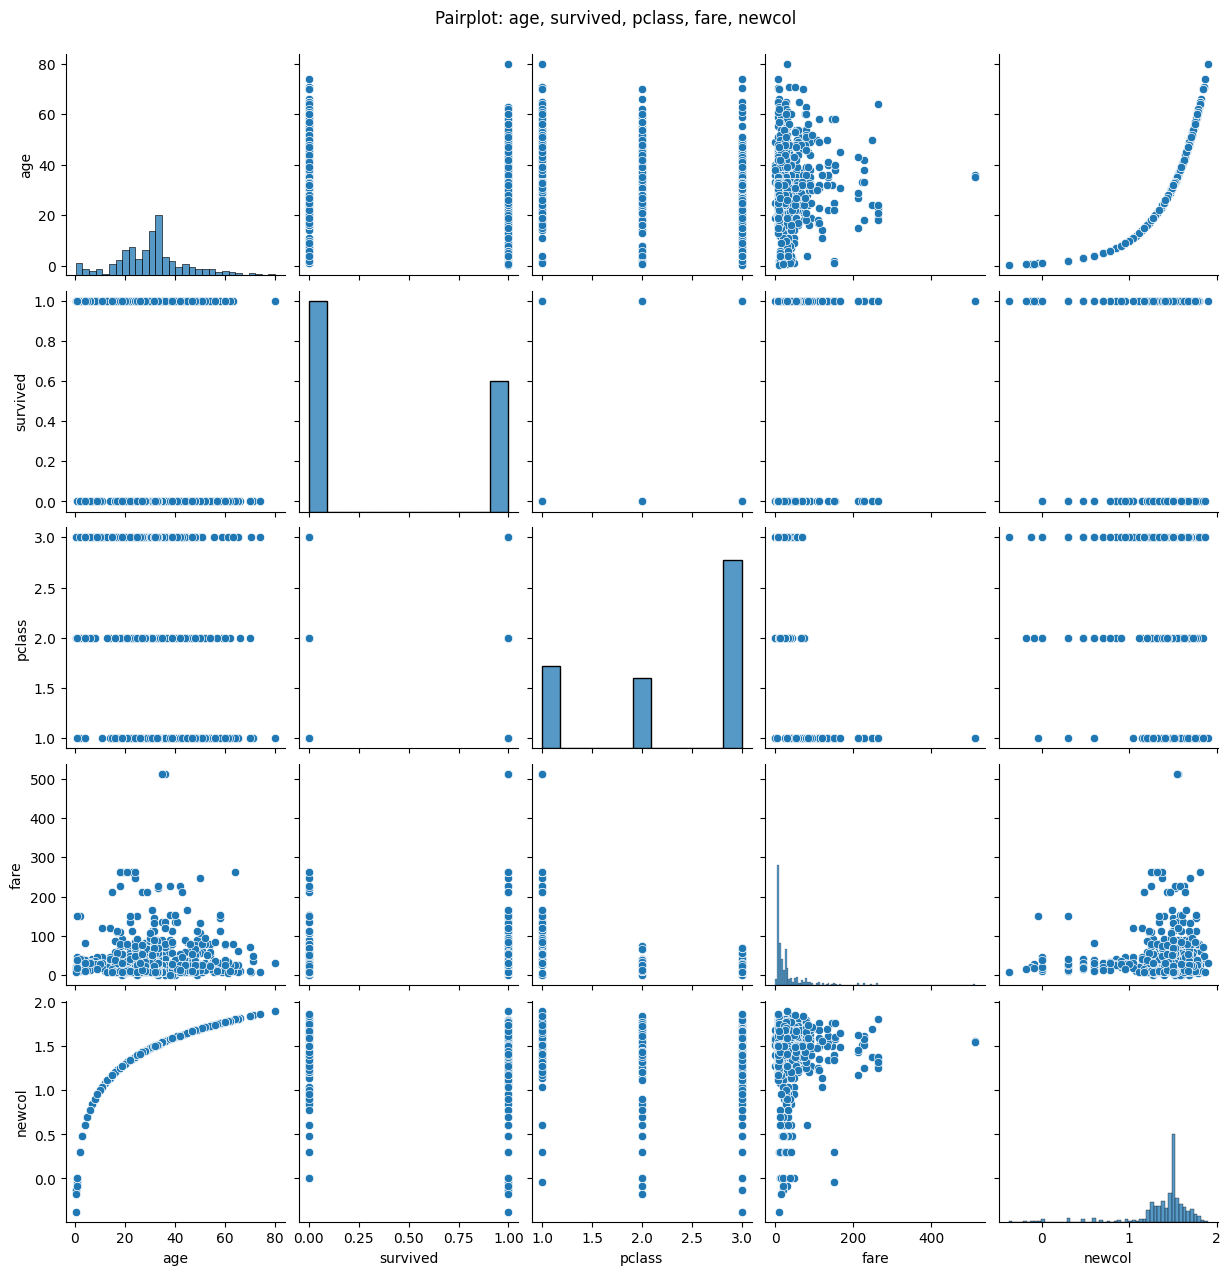

['survived', 'pclass', 'fare', 'newcol']

In [46]:
# ---------------------------------
# 4.- plot_features_num_regression
#----------------------------------
plot_features_num_regression(df, target_col="age", columns=[], umbral_corr=0, pvalue=None)

In [47]:
# ---------------------------------
# 5.- get_features_cat_regresion
#----------------------------------
get_features_cat_regresion(df, target_col="age", pvalue = 0.05)

['survived', 'pclass', 'class', 'who', 'alive', 'alone']

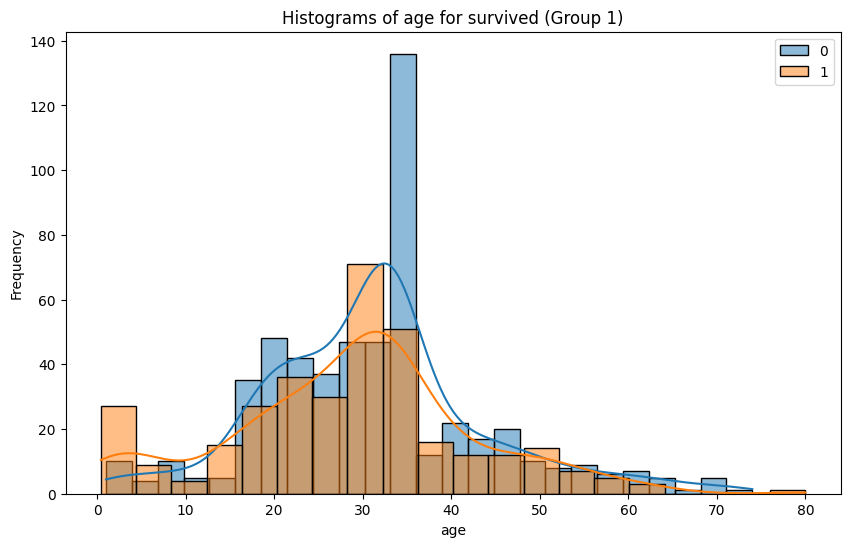

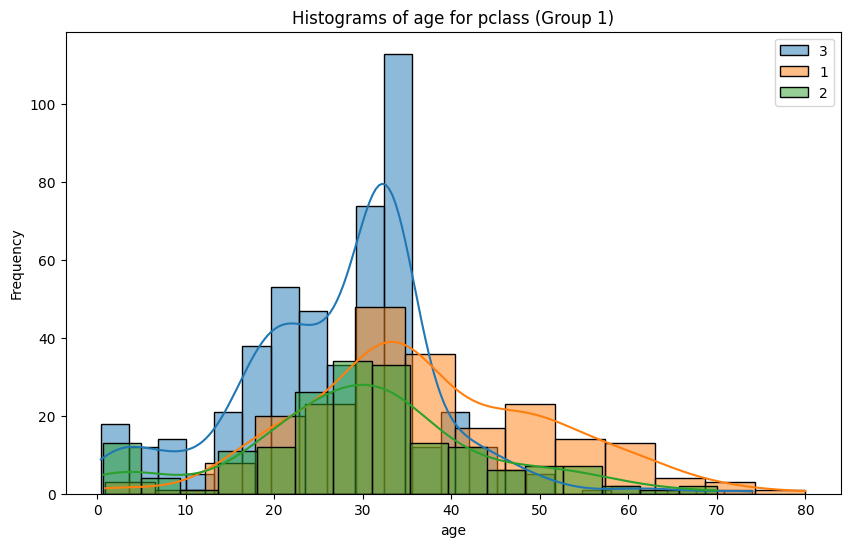

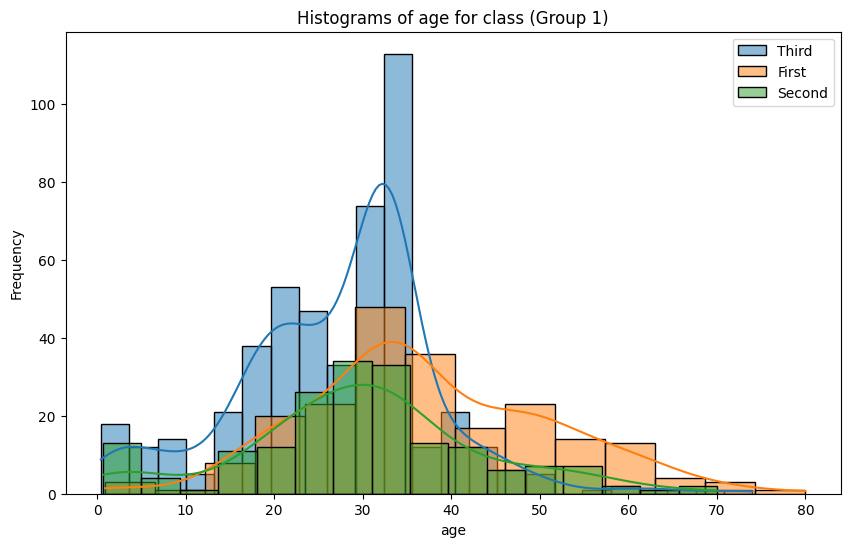

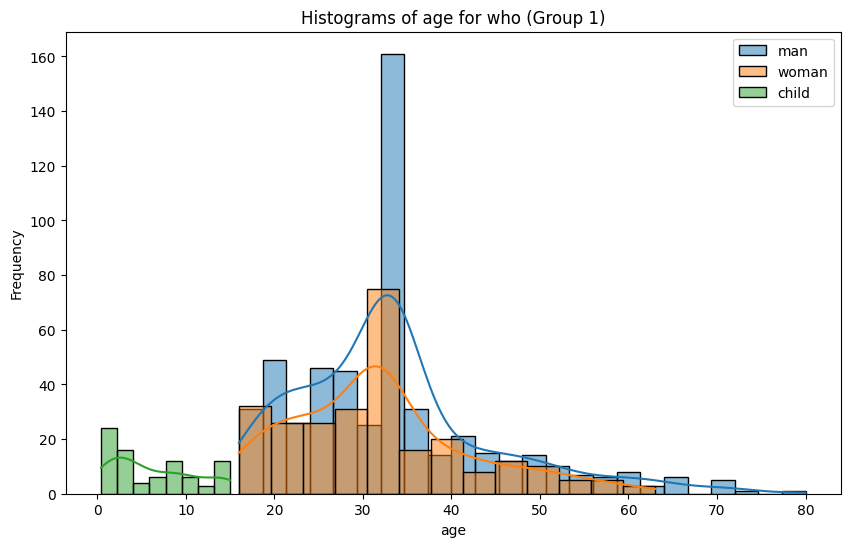

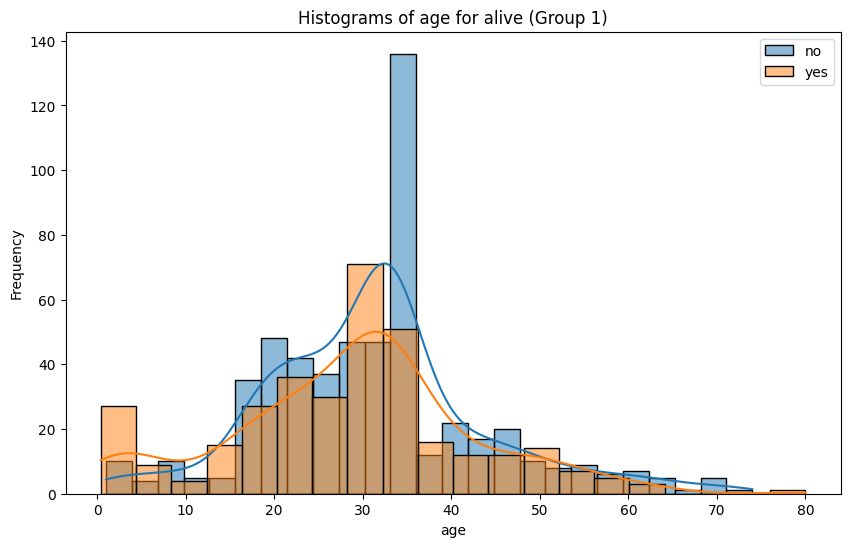

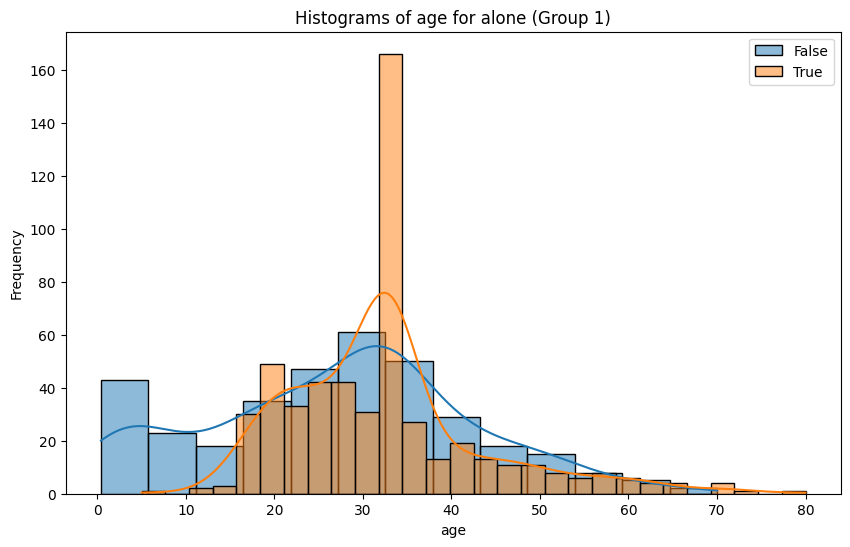

Las variables solicitadas que tienen relación estadística con 'target' son ['survived', 'pclass', 'class', 'who', 'alive', 'alone']


In [56]:
# ---------------------------------
# 6.- plot_features_cat_regresion
#----------------------------------
plot_features_cat_regresion(df, "age", pvalue = 0.05, columns = df.columns.tolist(), with_individual_plot = False)

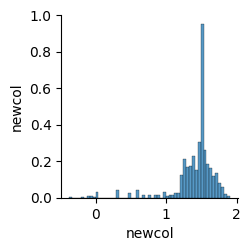

In [59]:
# ---------------------------------
# 6.- plot_features_cat_regresion
#----------------------------------
plot_features_cat_regresion(df, "fare", pvalue = 0.05, columns = [], with_individual_plot = False)